# Preparación del entorno

In [1]:
!unzip drive/MyDrive/Colab\ Notebooks/TFT.zip -d .
!unzip drive/MyDrive/Colab\ Notebooks/data.zip -d ./TFT/data/trayectorias/
!unzip drive/MyDrive/Colab\ Notebooks/data_sep.zip -d ./TFT/data/trayectorias/

!pip uninstall -y torch torchvision torchaudio torchdata torchtext

!pip install -r ./TFT/tft/requirements.txt
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 torchdata==0.5.1 torchtext==0.14.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install pytorch_lightning==1.6.4
!pip install pytorch_forecasting==0.10.1
!pip install torchmetrics==0.5.0

Archive:  drive/MyDrive/Colab Notebooks/TFT.zip
   creating: ./TFT/
   creating: ./TFT/data/
   creating: ./TFT/data/trayectorias/
  inflating: ./TFT/Environment_preparation.ipynb  
   creating: ./TFT/tft/
   creating: ./TFT/tft/data_formatters/
  inflating: ./TFT/tft/data_formatters/base.py  
  inflating: ./TFT/tft/data_formatters/electricity.py  
  inflating: ./TFT/tft/data_formatters/favorita.py  
  inflating: ./TFT/tft/data_formatters/traffic.py  
  inflating: ./TFT/tft/data_formatters/volatility.py  
  inflating: ./TFT/tft/data_formatters/__init__.py  
   creating: ./TFT/tft/expt_settings/
  inflating: ./TFT/tft/expt_settings/configs.py  
  inflating: ./TFT/tft/expt_settings/__init__.py  
   creating: ./TFT/tft/libs/
  inflating: ./TFT/tft/libs/hyperparam_opt.py  
  inflating: ./TFT/tft/libs/tft_model.py  
  inflating: ./TFT/tft/libs/utils.py  
  inflating: ./TFT/tft/libs/__init__.py  
  inflating: ./TFT/tft/README.md     
  inflating: ./TFT/tft/requirements.txt  
  inflating: ./T

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages th

# Carga de datos

In [2]:
# %cd tft

# Generic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
# Pytorch / Pytorch lightning dependencies
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
# Pytorch Forecasting library
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import SMAPE, MAE, RMSE, PoissonLoss, QuantileLoss, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pytorch_forecasting.data import NaNLabelEncoder

from torchmetrics import MeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler

In [3]:
df_all = pd.read_csv("./TFT/data/trayectorias/data.csv", encoding='utf8', index_col=0, low_memory=False)
features = ['latitude', 'longitude', 'altitude', 'hav_distance', 'speed']

# Preparación de scalers
scalers = {}
for f in features:
    scalers[f] = MinMaxScaler(feature_range=(0,1),copy=True).fit(df_all[[f]])

In [4]:
def transform_data(df: pd.DataFrame, saltar_gaps=False) -> pd.DataFrame:
    df = df.rename({'aerodromeOfDeparture':'ruta'},axis=1)

    #Escalo los valores
    for f in features:
        df[f] = scalers[f].transform(df[[f]])

    if saltar_gaps:
        last_id, last_timestamp = df.fpId[0], df.timestamp[0]
        counter = 0
        diffs = []
        for idx, row in df[['timestamp','fpId']].iterrows():
            if row.fpId != last_id:
                last_id = row.fpId
                last_timestamp = row.timestamp
                counter = 0
            elif (row.timestamp-last_timestamp) > 180:
                counter += 1
                last_timestamp = row.timestamp
            diffs.append(counter)
        df['segment'] = diffs
        df['id'] = df['fpId'] + '-' + df['segment'].astype(str)
        df = df.drop('segment', axis=1)
    else:
        df['id'] = df['fpId'].copy()
    # Cambiamos de granularidad en segundos (donde hay saltos en los timesteps: 5-10-14-19-26...)
    # al bucket de 15 segundos en el que se encuentra el vector (que debería reducir mucho los huecos)
    df['timestamp'] = (df['timestamp'] - df_all['timestamp'].min()).astype(int)
    df['timestamp'] = df['timestamp']//15

    # others
    df['categorical_id'] = df.ruta
    df = df[['id','timestamp','latitude','longitude','altitude','track','sector','hav_distance','speed','ruta']].copy() # 'categorical_id',
    df['sector'] = df['sector'].astype(str)

    # df = df.sort_values(by='timestamp')
    # df = df.reset_index(drop=True)

    return df

In [6]:
# df_train = pd.read_csv("./TFT/data/trayectorias/train.csv", encoding='utf8', index_col=0)
df_test  = pd.read_csv("./TFT/data/trayectorias/test.csv", encoding='utf8', index_col=0)
df_val   = pd.read_csv("./TFT/data/trayectorias/val.csv", encoding='utf8', index_col=0)
# train.csv no tiene la columna sector!! Buscar la versión que sí la tenga
df_train = df_all.iloc[:-(df_test.shape[0]+df_val.shape[0])].copy()

df_all   = transform_data(df_all)
df_train = transform_data(df_train)
df_test  = transform_data(df_test)
df_val   = transform_data(df_val)

<ipython-input-6-819ae1070fec>:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test  = pd.read_csv("./TFT/data/trayectorias/test.csv", encoding='utf8', index_col=0)
<ipython-input-6-819ae1070fec>:3: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_val   = pd.read_csv("./TFT/data/trayectorias/val.csv", encoding='utf8', index_col=0)


In [7]:
max_prediction_length = 10 # predict max 1 day ahead
max_encoder_length = 60 #using last 7 days

batch_size = 128

encoders = dict(
    id=NaNLabelEncoder().fit(df_all.id)
)

def prepare_dataset(df: pd.DataFrame, dataloader_conf=None):
    if dataloader_conf is None:
        dataset = TimeSeriesDataSet(
            df,
            time_idx="timestamp", # variable that contains the time index
            target=["latitude","longitude","altitude"],
            group_ids=["id"], # Groups used for later normalizing
            min_encoder_length=max_encoder_length,# // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            static_categoricals=["id"], # they do not change along a same time index
            static_reals=[], # same as before but real values
            time_varying_unknown_categoricals=["sector","ruta"],
            time_varying_unknown_reals=["latitude","longitude","altitude","track","hav_distance","speed"],
            categorical_encoders = encoders,
            allow_missing_timesteps = True,
            target_normalizer=MultiNormalizer([TorchNormalizer(),TorchNormalizer(),TorchNormalizer()]),
            add_relative_time_idx=True,
            add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
            add_encoder_length=True, # adds decoder length to list of static real variables.
        )
    else:
        dataset = TimeSeriesDataSet.from_dataset(
            dataloader_conf,
            df)
            # min_prediction_idx=validation_cutoff+1

    return dataset

# Preparamos sobre all para que no haya problemas con scalers y encoders
# Trasladamos la configuración sobre los respectivos datasets
all_dataset   = prepare_dataset(df_all)
train_dataset = prepare_dataset(df_train, all_dataset)
test_dataset  = prepare_dataset(df_test, all_dataset)
val_dataset   = prepare_dataset(df_val, all_dataset)

train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader   = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=2)
test_dataloader  = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 33 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__id': 'AT03075869'}, {'__group_id__id': 'AT04126877'}, {'__group_id__id': 'AT04780584'}, {'__group_id__id': 'AT04964385'}, {'__group_id__id': 'AT05217841'}, {'__group_id__id': 'AT05325960'}, {'__group_id__id': 'AT05421246'}, {'__group_id__id': 'AT05510200'}, {'__group_id__id': 'AT05529128'}, {'__group_id__id': 'AT05652888'}]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 22 series/groups which therefore are not present in the dataset index. This means no p

In [8]:
# Liberamos memoria
del all_dataset
del df_all

# Entrenamiento del modelo

In [19]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("trayectorias_logs4")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=120,
    # gpus=1, #1 for gpu
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    # shuffle=True ???
)

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.1,
    hidden_size=200,  # most important hyperparameter apart from learning rate
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,
    output_size=[7,7,7],
    logging_metrics = nn.ModuleList([MeanSquaredError()]),
    reduce_on_plateau_patience=5,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [20]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 715 K 
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 253 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 255 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 35.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 161 K 
8  | static_context_initial_hidden

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Evaluación

In [9]:
obj_features = ('latitude','longitude','altitude')

metrics = dict(
    MAE=MeanAbsoluteError(),
    RMSE=MeanSquaredError(squared=False),
    MSE=MeanSquaredError(),
)

best_tft = TemporalFusionTransformer.load_from_checkpoint("./TFT/tft/trayectorias_logs4/lightning_logs/12TFTTrack_ah4_u200_lb60/checkpoints/best.ckpt")

# Si CUDA está disponible
# best_tft.cuda()

# best_model_path = trainer.checkpoint_callback.best_model_path
# print(best_model_path)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
fast_dev_run = False

# Predicción
predictions_sc = best_tft.predict(test_dataloader, show_progress_bar=True, fast_dev_run=fast_dev_run)

Predict:   0%|          | 0/2656 [00:00<?, ? batches/s]

In [ ]:
preds = {}
# Valores desescalados
for idx, f in enumerate(obj_features):
    preds[f] = scalers[f].inverse_transform(predictions_sc[idx].numpy())
    preds[f] = torch.from_numpy(preds[f])

In [ ]:
from itertools import islice

# Valores reales
actuals = []
for idx, f in enumerate(obj_features):
    if fast_dev_run:
        vals = torch.cat([y[0][idx] for x, y in tqdm(islice(iter(test_dataloader), 1))])
    else:
        vals = torch.cat([y[0][idx] for x, y in iter(test_dataloader)])
    vals = scalers[f].inverse_transform(vals.numpy())
    actuals.append(torch.from_numpy(vals))

In [5]:
# Borrar - test gaps
pepe = df_all[['fpId','timestamp']].copy()
pepe2 = pepe.iloc[:-1].copy().reset_index(drop=True)
pepe2 = pepe2.rename({'timestamp':'timestamp2','fpId':'fpId2'}, axis=1)

pepe = pepe.iloc[1:].copy().reset_index(drop=True)
pepe = pepe.join(pepe2)
pepe['diffs'] = pepe.timestamp - pepe.timestamp2
print(pepe.shape)
pepe = pepe[pepe.fpId == pepe.fpId2].dropna(subset=['diffs'])
print(pepe.shape)

px.histogram(pepe[pepe.diffs>179], x='diffs', nbins=int(pepe.diffs.max()//30)+1, log_y=True)

(2971107, 5)
(2963962, 5)


,fpId,timestamp,fpId2,timestamp2,diffs
0,AT05414795,1641015901,AT05414795,1641015885,16
1,AT05414795,1641015916,AT05414795,1641015901,15
2,AT05414795,1641015934,AT05414795,1641015916,18
3,AT05414795,1641015946,AT05414795,1641015934,12
4,AT05414795,1641015962,AT05414795,1641015946,16


In [ ]:
# Borrar - test de ventanas

test_data = pd.DataFrame(
    [(y,x,x,100*idx+x,100*idx+x) for idx, y in enumerate('abcde') for x in range(10)],
    columns=('id', 'timestamp', 'col1', 'col2', 'col3')
)

ds = TimeSeriesDataSet(
            test_data,
            time_idx="timestamp", # variable that contains the time index
            target=["col3"],
            group_ids=["id"], # Groups used for later normalizing
            min_encoder_length=3,# // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=3,
            max_prediction_length=2,
            static_categoricals=["id"], # they do not change along a same time index
            static_reals=[], # same as before but real values
            time_varying_unknown_categoricals=[],
            time_varying_unknown_reals=["col1", "col2"],
            categorical_encoders = dict(id=NaNLabelEncoder().fit(test_data.id)),
            allow_missing_timesteps = True,
            target_normalizer=MultiNormalizer([TorchNormalizer()]),
            # add_relative_time_idx=True,
            # add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
            # add_encoder_length=True, # adds decoder length to list of static real variables.
        )
for i in ds:
    print(i)

## Métricas globales

In [15]:
for idx, f in enumerate(obj_features):
    # print(f' {f} '.center(48, '='))
    for name, calc in metrics.items():
        value = calc(preds[f], actuals[idx])
        print(f"TFT Model\t{name:<4}\t{f:<10} {value:>12.4f}")
    print()

TFT Model	MAE 	latitude         0.0342
TFT Model	RMSE	latitude         0.0437
TFT Model	MSE 	latitude         0.0019

TFT Model	MAE 	longitude        0.5942
TFT Model	RMSE	longitude        0.7136
TFT Model	MSE 	longitude        0.5093

TFT Model	MAE 	altitude       250.3073
TFT Model	RMSE	altitude       504.5087
TFT Model	MSE 	altitude    254529.0469



## Métricas en ventana

In [16]:
res_ventana_agg = []
for idx, f in enumerate(obj_features):
    # print(f' {f} '.center(48, '='))
    for name, calc in metrics.items():
        for pos in range(10):
            value = calc(preds[f][:,pos], actuals[idx][:,pos])
            # print(f"TFT Model\t{name:<4}\t{f:<10}\t{pos} {value:>12.4f}")
            res_ventana_agg.append((name, f, pos+1, value))
    print()
res_ventana_agg = pd.DataFrame(res_ventana_agg,
                               columns=('Metric', 'Feature', 'Position', 'Value'))

In [17]:
# Visualización

px.bar(data_frame=res_ventana_agg[(res_ventana_agg.Metric=='MAE') & (res_ventana_agg.Feature == 'altitude')],
       x='Position', y='Value', orientation='v',
       title='MAE en cada elemento de la ventana - Altitud',
       width=600, height= 400)

In [67]:
# Visualización

px.bar(data_frame=res_ventana_agg[(res_ventana_agg.Metric=='MAE') & (res_ventana_agg.Feature == 'latitude')],
       x='Position', y='Value', orientation='v',
       title='MAE en cada elemento de la ventana - Latitud',
       width=600, height= 400)

In [68]:
# Visualización

px.bar(data_frame=res_ventana_agg[(res_ventana_agg.Metric=='MAE') & (res_ventana_agg.Feature == 'longitude')],
       x='Position', y='Value', orientation='v',
       title='MAE en cada elemento de la ventana - Longitud',
       width=600, height= 400)

In [ ]:
## WIP

fig, ax = plt.subplots(3,3,figsize=(12,12))
for i in tqdm(range(9)):
  d = (pd.DataFrame(data[4])[[i]]-pd.DataFrame(data[5])[[i]]).abs()
  sns.histplot(data=d[d<10000], ax=ax[i//3][i%3], binwidth=100)
  ax[i//3][i%3].set_title(i)
  ax[i//3][i%3].set_yscale('log')
plt.show()

In [ ]:
# Borrar

# score = {"MSE" : best_tft.logging_metrics[0], "MAE" : MeanAbsoluteError()}
# results = []
# feats = ('lat','lon','alt')
# scalers = (scaler1, scaler2, scaler3)
# mets = ('MAE','MSE')
# data_names = []
# data = []

# for idx, feat in enumerate(feats):
#   a3 = scalers[idx].inverse_transform(predictions[idx].numpy())
#   t3 = torch.from_numpy(a3)
#   b3 = scalers[idx].inverse_transform(actuals[idx].numpy())
#   c3 = torch.from_numpy(b3)

#   data_names.append(f'pred_{feat}')
#   data.append(a3)
#   data_names.append(f'real_{feat}')
#   data.append(b3)
#   print(feat, score['MAE'](t3, c3))

#   for i in range(10):
#     for met in mets:
#       value = score[met](t3[:,i], c3[:,i])
#       results.append((met,feat,i,value.cpu().numpy()))

## Métricas por trayectoria

In [93]:
def predecir_trayectoria(tray):
    batch_size = 128

    evaluating_tray = prepare_dataset(tray, all_dataset)
    tray_dl = evaluating_tray.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

    predictions = best_tft.predict(tray_dl)

    for idx, f in enumerate(features):
        predictions[idx] = scalers[f].inverse_transform(predictions[idx].numpy())
        predictions[idx] = torch.from_numpy(predictions[idx])

    return predictions, tray_dl

In [106]:
# Agregados
res_trajectories = []
for tray in tqdm(df_test.id.unique()):
    pred, tray_dl = predecir_trayectoria(df_test[df_test.id == tray])

    for idx, f in enumerate(features):
        actuals3 = torch.cat([y[0][idx] for x, y in iter(tray_dl)])
        b3 = scalers[f].inverse_transform(actuals3.numpy())
        c3 = torch.from_numpy(b3)

        for name, calc in metrics.items():
            value = float(calc(t3, c3).numpy())
            res_trajectories.append((tray, f, name, value))
    break
res_trajectories = pd.DataFrame(res_trajectories, columns=('Trajectory', 'Metric', 'Feature', 'Value'))

  0%|          | 0/1078 [00:06<?, ?it/s]


In [ ]:
# Visualización

In [114]:
tray = 'AT05442310'

results = []
pred, tray_dl = predecir_trayectoria(df_test[df_test.id == tray])

for idx, f in enumerate(features):
  if f == 'lat' or f == 'lon':
    continue

  actuals3 = torch.cat([y[0][idx] for x, y in iter(tray_dl)])
  timestamps = torch.cat([x['decoder_time_idx'][:,-1] for x, y in iter(tray_dl)])
  b3 = scalers[f].inverse_transform(actuals3.numpy())
  c3 = torch.from_numpy(b3)

  for name, calc in metrics.items():
    value = calc(t3, c3)

mensaje = 1
preds = np.array([x[mensaje-1] for x in t3.numpy()])
reals = np.array([x[mensaje-1] for x in c3.numpy()])
df = pd.DataFrame(preds, columns=['preds'])
df['real'] = reals
df['timestamp'] = timestamps

# preds = np.array([x[-1] for x in t3.numpy()])
# reals = np.array([x[-1] for x in c3.numpy()])
# df['preds2'] = preds
# df['real2'] = reals           ['preds','preds2','real','real2']
px.scatter(data_frame=df, y=['preds','real'], x='timestamp', title=f'{tray} - Mensaje {mensaje}', width=1000)

# ANTERIOR

## Tests

In [53]:
tr = pd.read_csv('./data/trayectorias/train.csv')
te = pd.read_csv('./data/trayectorias/test.csv')
va = pd.read_csv('./data/trayectorias/val.csv')
min_timestamp = pd.concat([tr.timestamp, te.timestamp, va.timestamp]).min()

tr['timestamp'] = (tr['timestamp'] - min_timestamp).astype(int)
tr['timestamp'] = tr['timestamp']//15

te['timestamp'] = (te['timestamp'] - min_timestamp).astype(int)
te['timestamp'] = te['timestamp']//15

va['timestamp'] = (va['timestamp'] - min_timestamp).astype(int)
va['timestamp'] = va['timestamp']//15

<ipython-input-53-0728a8956026>:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  tr = pd.read_csv('./data/trayectorias/train.csv')
<ipython-input-53-0728a8956026>:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  te = pd.read_csv('./data/trayectorias/test.csv')
<ipython-input-53-0728a8956026>:3: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  va = pd.read_csv('./data/trayectorias/val.csv')


In [54]:
print(f"Total vectores: {trayectorias_df.shape[0]:>10}")
print(f"Vectores train: {tr.shape[0]:>10}")
print(f"Vectores val:   {va.shape[0]:>10}")
print(f"Vectores test:  {te.shape[0]:>10}")

Total vectores:    2971108
Vectores train:    2141283
Vectores val:       383183
Vectores test:      446642


In [55]:
print(f"Total vectores: {trayectorias_df.shape[0]:>10}")
print(f"Vectores train: {trayectorias_df[lambda x: x.timestamp <= training_cutoff].shape[0]:>10}")
print(f"Vectores val:   {trayectorias_df[(trayectorias_df.timestamp<=validation_cutoff) & (trayectorias_df.timestamp>=training_cutoff+1)].shape[0]:>10}")
print(f"Vectores test:  {trayectorias_df[trayectorias_df.timestamp>=validation_cutoff+1].shape[0]:>10}")

Total vectores:    2971108
Vectores train:    2141292
Vectores val:       383177
Vectores test:      446639


In [59]:
print(f'{trayectorias_df.timestamp.min():>10}',
      f'{trayectorias_df.timestamp.max():>10}')
print(f'{tr.timestamp.min():>10}',
      f'{tr.timestamp.max():>10}')
print(f'{va.timestamp.min():>10}',
      f'{va.timestamp.max():>10}')
print(f'{te.timestamp.min():>10}',
      f'{te.timestamp.max():>10}')

         0    1570780
        69    1570660
      7049    1570699
         0    1570780


In [57]:
print(trayectorias_df.timestamp.min(),
      trayectorias_df.timestamp.max())
print(trayectorias_df[lambda x: x.timestamp <= training_cutoff].timestamp.min(),
      trayectorias_df[lambda x: x.timestamp <= training_cutoff].timestamp.max())
print(trayectorias_df[(trayectorias_df.timestamp<=validation_cutoff) & (trayectorias_df.timestamp>training_cutoff)].timestamp.min(),
      trayectorias_df[(trayectorias_df.timestamp<=validation_cutoff) & (trayectorias_df.timestamp>training_cutoff)].timestamp.max())
print(trayectorias_df[trayectorias_df.timestamp>=validation_cutoff+1].timestamp.min(),
      trayectorias_df[trayectorias_df.timestamp>=validation_cutoff+1].timestamp.max())

0 1570780
0 1188407
1188408 1383508
1383509 1570780


In [27]:
len(training)

1346081

In [32]:
len(validation)

252578

In [29]:
len(testing)

302239

## Preparación de datos

In [ ]:
trayectorias_df = pd.read_csv("./data/trayectorias/test.csv", encoding='utf8', index_col=0)
trayectorias_df = trayectorias_df.rename({'aerodromeOfDeparture':'ruta'},axis=1)

<ipython-input-3-4157ab8733f3>:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  trayectorias_df = pd.read_csv("./data/trayectorias/test.csv", encoding='utf8', index_col=0)


In [ ]:
# trayectorias_df['hav_distance'] = trayectorias_df.hav_distance // 40 * 40

<Axes: xlabel='hav_distance', ylabel='Count'>

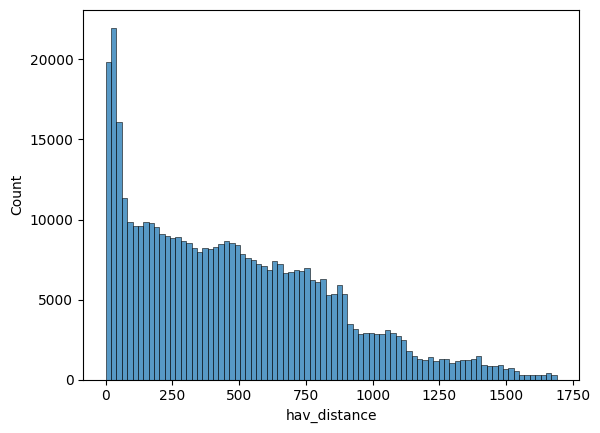

In [ ]:
# sns.histplot(trayectorias_df, x='hav_distance', binwidth=20)

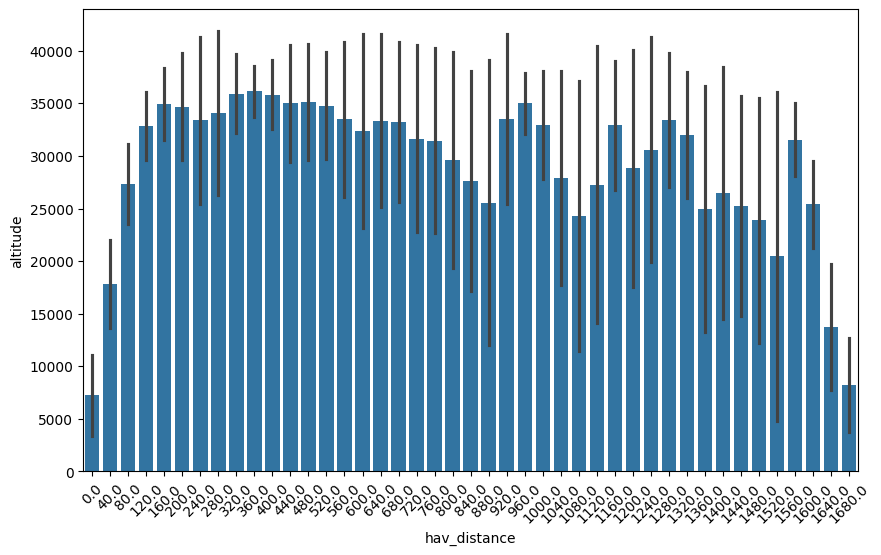

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(10,6))
# sns.barplot(trayectorias_df, x='hav_distance', y='altitude', errorbar='sd', ax=ax)
# plt.xticks(rotation=45);

In [ ]:
#Escalo los valores
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=(0,1),copy=True)
scaler2 = MinMaxScaler(feature_range=(0,1),copy=True)
scaler3 = MinMaxScaler(feature_range=(0,1),copy=True)
scaler4 = MinMaxScaler(feature_range=(0,1),copy=True)
scaler5 = MinMaxScaler(feature_range=(0,1),copy=True)
#["latitude","longitude","altitude"]

trayectorias_df[["latitude"]] = scaler1.fit_transform(trayectorias_df[["latitude"]])
trayectorias_df[["longitude"]] = scaler2.fit_transform(trayectorias_df[["longitude"]])
trayectorias_df[["altitude"]] = scaler3.fit_transform(trayectorias_df[["altitude"]])
trayectorias_df[["hav_distance"]] = scaler4.fit_transform(trayectorias_df[["hav_distance"]])
trayectorias_df[["speed"]] = scaler5.fit_transform(trayectorias_df[["speed"]])

trayectorias_df['id'] = trayectorias_df['fpId'].copy()

# Cambiamos de granularidad en segundos (donde hay saltos en los timesteps: 5-10-14-19-26...)
# al bucket de 15 segundos en el que se encuentra el vector (que debería reducir mucho los huecos)
trayectorias_df['timestamp'] = (trayectorias_df['timestamp'] - trayectorias_df['timestamp'].min()).astype(int)
trayectorias_df['timestamp'] = trayectorias_df['timestamp']//15

# others
trayectorias_df['categorical_id'] = trayectorias_df.ruta
trayectorias_df = trayectorias_df[['id','timestamp','latitude','longitude','altitude','track','sector','hav_distance','speed','ruta']].copy() # 'categorical_id',
trayectorias_df['sector'] = trayectorias_df['sector'].astype(str)
# trayectorias_df

trayectorias_df = trayectorias_df.sort_values(by='timestamp')

### Para evitar valores de index duplicados tras concatenar los datasets
trayectorias_df = trayectorias_df.reset_index(drop=True)

In [ ]:
max_prediction_length = 10 # predict max 1 day ahead
max_encoder_length = 60 #using last 7 days

evaluating = TimeSeriesDataSet(
    trayectorias_df,
    time_idx="timestamp", # variable that contains the time index
    target=["latitude","longitude","altitude"],
    group_ids=["id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length,# // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id","ruta"], # they do not change along a same time index
    static_reals=[], # same as before but real values
    time_varying_unknown_categoricals=["sector","ruta"],
    time_varying_unknown_reals=["latitude","longitude","altitude","track","hav_distance","speed"],
    categorical_encoders = encoders,
    allow_missing_timesteps = True,
    target_normalizer=MultiNormalizer([TorchNormalizer(),TorchNormalizer(),TorchNormalizer()]),
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
    add_encoder_length=True, # adds decoder length to list of static real variables.
)

batch_size = 128  # set this between 32 to 128
test_dataloader = evaluating.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 7 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__id': 'AT03075869'}, {'__group_id__id': 'AT04126877'}, {'__group_id__id': 'AT04780584'}, {'__group_id__id': 'AT05812717'}, {'__group_id__id': 'AT05859074'}, {'__group_id__id': 'AT05985954'}, {'__group_id__id': 'AT06803409'}]
  warnings.warn(


In [ ]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("trayectorias_logs4")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=120,
    # gpus=1, #1 for gpu
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

best_tft = TemporalFusionTransformer.load_from_checkpoint("tft/trayectorias_logs4/lightning_logs/12TFTTrack_ah4_u200_lb60/checkpoints/best.ckpt")
# Si CUDA está disponible
# best_tft.cuda()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


## Métricas globales

In [ ]:
score = {"MSE" : best_tft.logging_metrics[0]}
predictions = best_tft.predict(test_dataloader)

#primero escalado
tft_MSE = score["MSE"](predictions[0], torch.cat([y[0][0] for x, y in iter(test_dataloader)]))
print(f"TFT Model MSE latitude escalado: {tft_MSE:.10f}")

tft_MSE = score["MSE"](predictions[1], torch.cat([y[0][1] for x, y in iter(test_dataloader)]))
print(f"TFT Model MSE longitude escalado: {tft_MSE:.10f}")

tft_MSE = score["MSE"](predictions[2], torch.cat([y[0][2] for x, y in iter(test_dataloader)]))
print(f"TFT Model MSE altitude escalado: {tft_MSE:.10f}")

#luego desescalado
a1=scaler1.inverse_transform(predictions[0].numpy())
a2=scaler2.inverse_transform(predictions[1].numpy())
a3=scaler3.inverse_transform(predictions[2].numpy())

t1 = torch.from_numpy(a1)
t2 = torch.from_numpy(a2)
t3 = torch.from_numpy(a3)

pred_desescalado = [t1,t2,t3]

actuals1 = torch.cat([y[0][0] for x, y in iter(test_dataloader)])
b1 = scaler1.inverse_transform(actuals1.numpy())
c1 = torch.from_numpy(b1)
tft_MSE = score["MSE"](pred_desescalado[0], c1)
print(f"TFT Model MSE latitude: {tft_MSE:.10f}")

actuals2 = torch.cat([y[0][1] for x, y in iter(test_dataloader)])
b2 = scaler2.inverse_transform(actuals2.numpy())
c2 = torch.from_numpy(b2)
tft_MSE = score["MSE"](pred_desescalado[1], c2)
print(f"TFT Model MSE longitude: {tft_MSE:.10f}")

actuals3 = torch.cat([y[0][2] for x, y in iter(test_dataloader)])
b3 = scaler3.inverse_transform(actuals3.numpy())
c3 = torch.from_numpy(b3)
tft_MSE = score["MSE"](pred_desescalado[2], c3)
print(f"TFT Model MSE altitude: {tft_MSE:.10f}")

In [ ]:
# predictions = best_tft.predict(test_dataloader)

In [ ]:
score = {"MSE" : best_tft.logging_metrics[0], "MAE" : MeanAbsoluteError()}

#luego desescalado
a3=scaler3.inverse_transform(predictions[2].numpy())

t3 = torch.from_numpy(a3)

actuals3 = torch.cat([y[0][2] for x, y in iter(test_dataloader)])
b3 = scaler3.inverse_transform(actuals3.numpy())
c3 = torch.from_numpy(b3)
tft_MSE = score["MSE"](t3, c3)
print(f"TFT Model MSE altitude: {tft_MSE:.10f}")

tft_MAE = score["MAE"](t3, c3)
print(f"TFT Model MAE altitude: {tft_MAE:.10f}")

tft_RMSE = MeanSquaredError(squared=False)(t3, c3)
print(f"TFT Model RMSE altitude: {tft_RMSE:.10f}")

TFT Model MSE altitude: 313446.0937500000
TFT Model MAE altitude: 232.1445922852
TFT Model RMSE altitude: 559.8625488281


In [ ]:
pepe = pd.DataFrame(zip(
    test_dataloader.dataset.categorical_encoders['id'].inverse_transform(test_dataloader.dataset.data['groups']),
    test_dataloader.dataset.categorical_encoders['ruta'].inverse_transform(test_dataloader.dataset.data['categoricals'][:,1]),
    scaler4.inverse_transform(test_dataloader.dataset.scalers['hav_distance'].inverse_transform(test_dataloader.dataset.data['reals'][:, -2:-1])),
    test_dataloader.dataset.data['time'],
    t3, c3),
    columns=['trayectoria','ruta','distancia','timestamp_minimizado','alt_preds','alt_real'])
pepe['MAE'] = pepe.loc[:,['alt_preds','alt_real']].apply(lambda x: score["MAE"](x.loc['alt_preds'], x.loc['alt_real']), axis=1)
pepe['MSE'] = pepe.loc[:,['alt_preds','alt_real']].apply(lambda x: score["MSE"](x.loc['alt_preds'], x.loc['alt_real']), axis=1)
pepe = pepe.drop(['alt_preds','alt_real'], axis=1)
pepe['trayectoria'] = pepe.trayectoria.apply(lambda x: x.item())
pepe['distancia'] = pepe.distancia.apply(lambda x: x.item())
pepe['timestamp_minimizado'] = pepe.timestamp_minimizado.apply(lambda x: x.item())
pepe['MAE'] = pepe.MAE.apply(lambda x: x.item())
pepe['MSE'] = pepe.MSE.apply(lambda x: x.item())

In [ ]:
pepe.to_parquet('output.parquet')

## Métricas por trayectoria

In [ ]:
score = {"MSE" : best_tft.logging_metrics[0], "MAE" : MeanAbsoluteError()}

def predecir_trayectoria(tray):
  evaluating_tray = TimeSeriesDataSet(
    trayectorias_df[trayectorias_df.id==tray],
    time_idx="timestamp", # variable that contains the time index
    target=["latitude","longitude","altitude"],
    group_ids=["id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length,# // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id","ruta"], # they do not change along a same time index
    static_reals=[], # same as before but real values
    time_varying_unknown_categoricals=["sector","ruta"],
    time_varying_unknown_reals=["latitude","longitude","altitude","track","hav_distance","speed"],
    categorical_encoders = encoders,
    allow_missing_timesteps = True,
    target_normalizer=MultiNormalizer([TorchNormalizer(),TorchNormalizer(),TorchNormalizer()]),
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
    add_encoder_length=True, # adds decoder length to list of static real variables.
  )

  batch_size = 128  # set this between 32 to 128
  tray_dl = evaluating_tray.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

  predictions = best_tft.predict(tray_dl)

  return predictions, tray_dl

In [ ]:
tray = 'AT05429397'
pred, tray_dl = predecir_trayectoria(tray)

In [ ]:
trayectorias_df.id.unique()[:10]

array(['AT05412486', 'AT05429271', 'AT05429397', 'AT05434060',
       'AT05428627', 'AT05442310', 'AT05443640', 'AT05449192',
       'AT05453576', 'AT05461988'], dtype=object)

In [ ]:
tray = 'AT05442310'

results = []
feats = ('lat','lon','alt')
scalers = (scaler1, scaler2, scaler3)
mets = ('MAE','MSE')
pred, tray_dl = predecir_trayectoria(tray)

for idx, feat in enumerate(feats):
  if feat == 'lat' or feat == 'lon':
    continue
  a3 = scalers[idx].inverse_transform(pred[idx].numpy())
  t3 = torch.from_numpy(a3)

  actuals3 = torch.cat([y[0][idx] for x, y in iter(tray_dl)])
  timestamps = torch.cat([x['decoder_time_idx'][:,-1] for x, y in iter(tray_dl)])
  b3 = scalers[idx].inverse_transform(actuals3.numpy())
  c3 = torch.from_numpy(b3)

  for met in mets:
    value = score[met](t3, c3)
    # results[-1][f'{met}_{feat}'] = value

mensaje = 1
preds = np.array([x[mensaje-1] for x in t3.numpy()])
reals = np.array([x[mensaje-1] for x in c3.numpy()])
df = pd.DataFrame(preds, columns=['preds'])
df['real'] = reals
df['timestamp'] = timestamps

# preds = np.array([x[-1] for x in t3.numpy()])
# reals = np.array([x[-1] for x in c3.numpy()])
# df['preds2'] = preds
# df['real2'] = reals           ['preds','preds2','real','real2']
px.scatter(data_frame=df, y=['preds','real'], x='timestamp', title=f'{tray} - Mensaje {mensaje}', width=1000)

In [ ]:
results = []
feats = ('lat','lon','alt')
scalers = (scaler1, scaler2, scaler3)
mets = ('MAE','MSE')

for tray in tqdm(trayectorias_df.id.unique()):
  # tray = 'AT05429397'
  pred, tray_dl = predecir_trayectoria(tray)
  results.append(dict(
      trayectoria=tray
  ))

  for idx, feat in enumerate(feats):
    a3 = scalers[idx].inverse_transform(pred[idx].numpy())
    t3 = torch.from_numpy(a3)

    actuals3 = torch.cat([y[0][idx] for x, y in iter(tray_dl)])
    b3 = scalers[idx].inverse_transform(actuals3.numpy())
    c3 = torch.from_numpy(b3)

    for met in mets:
      value = score[met](t3, c3)
      results[-1][f'{met}_{feat}'] = value


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


## Métricas en ventana

In [ ]:
fast_dev_run = False

predictions = best_tft.predict(test_dataloader, show_progress_bar=True, fast_dev_run=fast_dev_run)

Predict:   0%|          | 0/224 [00:00<?, ? batches/s]

In [ ]:
from itertools import islice

if fast_dev_run:
  actuals = [
      torch.cat([y[0][0] for x, y in tqdm(islice(iter(test_dataloader), 1))]),
      torch.cat([y[0][1] for x, y in tqdm(islice(iter(test_dataloader), 1))]),
      torch.cat([y[0][2] for x, y in tqdm(islice(iter(test_dataloader), 1))])
  ]
else:
  actuals = [
      torch.cat([y[0][0] for x, y in iter(test_dataloader)]),
      torch.cat([y[0][1] for x, y in iter(test_dataloader)]),
      torch.cat([y[0][2] for x, y in iter(test_dataloader)])
  ]

In [ ]:
score = {"MSE" : best_tft.logging_metrics[0], "MAE" : MeanAbsoluteError()}
results = []
feats = ('lat','lon','alt')
scalers = (scaler1, scaler2, scaler3)
mets = ('MAE','MSE')
data_names = []
data = []

for idx, feat in enumerate(feats):
  a3 = scalers[idx].inverse_transform(predictions[idx].numpy())
  t3 = torch.from_numpy(a3)
  b3 = scalers[idx].inverse_transform(actuals[idx].numpy())
  c3 = torch.from_numpy(b3)

  data_names.append(f'pred_{feat}')
  data.append(a3)
  data_names.append(f'real_{feat}')
  data.append(b3)
  print(feat, score['MAE'](t3, c3))

  for i in range(10):
    for met in mets:
      value = score[met](t3[:,i], c3[:,i])
      results.append((met,feat,i,value.cpu().numpy()))

lat tensor(0.0376)
lon tensor(0.1155)
alt tensor(232.1447)


### Distribución de error por posición en ventana

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


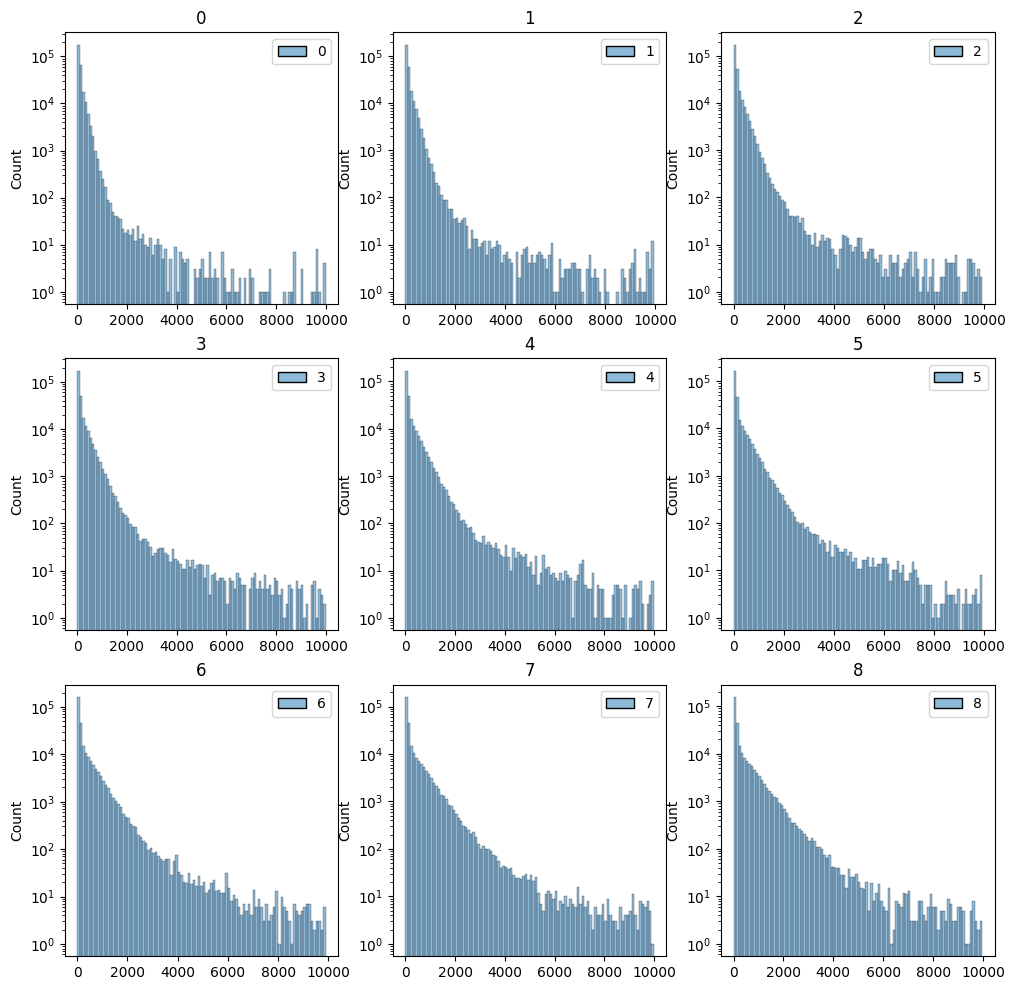

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(12,12))
for i in tqdm(range(9)):
  d = (pd.DataFrame(data[4])[[i]]-pd.DataFrame(data[5])[[i]]).abs()
  sns.histplot(data=d[d<10000], ax=ax[i//3][i%3], binwidth=100)
  ax[i//3][i%3].set_title(i)
  ax[i//3][i%3].set_yscale('log')
plt.show()

### Valor medio por posición en ventana

In [ ]:
pepe = pd.DataFrame(results, columns=('Metric', 'Feature', 'Step', 'Value'))
pepe['Value'] = pepe.Value.astype('float')
pepe['Step'] += 1

In [ ]:
px.bar(data_frame=pepe[(pepe.Metric=='MAE') & (pepe.Feature == 'alt')],
       x='Step', y='Value', orientation='v',
       title='MAE en cada elemento de la ventana - Altitud',
       width=700, height= 500)

In [ ]:
px.bar(data_frame=pepe[(pepe.Metric=='MAE') & (pepe.Feature == 'lat')],
       x='Step', y='Value', orientation='v',
       title='MAE en cada elemento de la ventana - Latitud',
       width=700, height= 500)

In [ ]:
px.bar(data_frame=pepe[(pepe.Metric=='MAE') & (pepe.Feature == 'lon')],
       x='Step', y='Value', orientation='v',
       title='MAE en cada elemento de la ventana - Longitud',
       width=700, height= 500)

In [ ]:
a3=scaler3.inverse_transform(predictions[2].numpy())

t3 = torch.from_numpy(a3)

actuals3 = torch.cat([y[0][2] for x, y in iter(tray_dl)])
b3 = scaler3.inverse_transform(actuals3.numpy())
c3 = torch.from_numpy(b3)
tft_MSE = score["MSE"](t3, c3)
print(f"TFT Model MSE altitude: {tft_MSE:.10f}")

tft_MAE = score["MAE"](t3, c3)
print(f"TFT Model MAE altitude: {tft_MAE:.10f}")

TFT Model MSE altitude: 727744.6250000000
TFT Model MAE altitude: 516.7285766602


In [ ]:
print(score["MAE"](torch.from_numpy(reals), torch.from_numpy(preds)))
print(score["MSE"](torch.from_numpy(reals), torch.from_numpy(preds)))

tensor(362.2881)
tensor(272846.8125)


## Otros

In [ ]:
test_dataloader.dataset.scalers

{'encoder_length': StandardScaler(),
 'latitude_center': StandardScaler(),
 'latitude_scale': StandardScaler(),
 'longitude_center': StandardScaler(),
 'longitude_scale': StandardScaler(),
 'altitude_center': StandardScaler(),
 'altitude_scale': StandardScaler(),
 'relative_time_idx': StandardScaler(),
 'track': StandardScaler(),
 'hav_distance': StandardScaler(),
 'speed': StandardScaler()}

In [ ]:
test_dataloader.dataset.data

{'reals': tensor([[ 0.0000e+00,  3.3307e-16,  1.9429e-16,  ...,  9.6699e-01,
           3.2666e+00, -3.3209e+00],
         [ 0.0000e+00,  3.3307e-16,  1.9429e-16,  ...,  9.6699e-01,
           3.2670e+00, -3.0772e+00],
         [ 0.0000e+00,  3.3307e-16,  1.9429e-16,  ...,  9.6512e-01,
           3.2674e+00, -2.8591e+00],
         ...,
         [ 0.0000e+00,  3.3307e-16,  1.9429e-16,  ..., -3.1577e+00,
          -1.3035e+00, -3.0643e+00],
         [ 0.0000e+00,  3.3307e-16,  1.9429e-16,  ..., -3.1073e+00,
          -1.3070e+00, -3.2568e+00],
         [ 0.0000e+00,  3.3307e-16,  1.9429e-16,  ..., -3.1577e+00,
          -1.3082e+00, -3.6801e+00]]),
 'categoricals': tensor([[   0,   39,    0,   39],
         [   0,   39,    0,   39],
         [   0,   39,    0,   39],
         ...,
         [1077,   39,    1,   39],
         [1077,   39,    1,   39],
         [1077,   39,    1,   39]]),
 'groups': tensor([[   0],
         [   0],
         [   0],
         ...,
         [1077],
         [1

In [ ]:
test_dataloader.dataset.reals

['encoder_length',
 'latitude_center',
 'latitude_scale',
 'longitude_center',
 'longitude_scale',
 'altitude_center',
 'altitude_scale',
 'relative_time_idx',
 'latitude',
 'longitude',
 'altitude',
 'track',
 'hav_distance',
 'speed']

In [ ]:
test_dataloader.dataset.get_parameters()

{'time_idx': 'timestamp',
 'target': ['latitude', 'longitude', 'altitude'],
 'group_ids': ['id'],
 'weight': None,
 'max_encoder_length': 60,
 'min_encoder_length': 60,
 'min_prediction_idx': 0,
 'min_prediction_length': 10,
 'max_prediction_length': 10,
 'static_categoricals': ['id', 'ruta'],
 'static_reals': ['encoder_length',
  'latitude_center',
  'latitude_scale',
  'longitude_center',
  'longitude_scale',
  'altitude_center',
  'altitude_scale'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['relative_time_idx'],
 'time_varying_unknown_categoricals': ['sector', 'ruta'],
 'time_varying_unknown_reals': ['latitude',
  'longitude',
  'altitude',
  'track',
  'hav_distance',
  'speed'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': MultiNormalizer(normalizers=[TorchNormalizer(), TorchNormalizer(),

In [ ]:
pred_desescalado[2].shape

torch.Size([285825, 10])

In [ ]:
trayectorias_df.shape

(446642, 10)

## Old

In [ ]:
max_prediction_length = 10 # predict max 1 day ahead
max_encoder_length = 60 #using last 7 days

# Sets limit for training data (last index prior to max prediction sequence)
training_cutoff = trayectorias_df.iloc[-829825].timestamp
validation_cutoff = trayectorias_df.iloc[-446242].timestamp

training = TimeSeriesDataSet(
    trayectorias_df[lambda x: x.timestamp <= training_cutoff],
    time_idx="timestamp", # variable that contains the time index
    target=["latitude","longitude","altitude"],
    group_ids=["id"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length,# // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id"], # they do not change along a same time index
    static_reals=[], # same as before but real values
    time_varying_unknown_categoricals=["sector","ruta"],
    time_varying_unknown_reals=["latitude","longitude","altitude","track","hav_distance","speed"],
    categorical_encoders = encoders,
    allow_missing_timesteps = True,
    target_normalizer=MultiNormalizer([TorchNormalizer(),TorchNormalizer(),TorchNormalizer()]),
    add_relative_time_idx=True,
    add_target_scales=True, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
    add_encoder_length=True, # adds decoder length to list of static real variables.
)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__id': 'AT05412486'}]
  warnings.warn(


AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training,
    trayectorias_df[lambda x: x.timestamp <= validation_cutoff],
    min_prediction_idx=training_cutoff+1,
                                           )
testing = TimeSeriesDataSet.from_dataset(training,
    trayectorias_df,
    min_prediction_idx=validation_cutoff+1,
                                           )
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=6)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=6)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=6)

KeyError: "Unknown category 'EDDL' encountered. Set `add_nan=True` to allow unknown categories"

In [ ]:
for i in train_dataloader:
    for j in i:
        if type(j)==tuple:
            continue
        for k,v in j.items():
            if type(v)==list:
                print(v[0].shape)
            else:
                print(v.shape)
    break

NameError: name 'train_dataloader' is not defined

In [ ]:
from torchmetrics import MeanSquaredError
from torch import nn
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("trayectorias_logs4")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=120,
    #gpus=1, #1 for gpu
    weights_summary="top", #for printing a summary of the model parameters
    gradient_clip_val=0.1,
    limit_train_batches=320,  # training over batches of 320
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=200,  # most important hyperparameter apart from learning rate
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,
    output_size=[7,7,7],
    logging_metrics = nn.ModuleList([MeanSquaredError()]),
    reduce_on_plateau_patience=5,
)



In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


NameError: name 'trainer' is not defined

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint("trayectorias_logs4/lightning_logs/12TFTTrack_ah4_u200_lb60/checkpoints/best.ckpt")

NameError: name 'trainer' is not defined

In [ ]:
score = {"MSE" : best_tft.logging_metrics[0]}
predictions = best_tft.predict(test_dataloader)

#primero escalado
tft_MSE = score["MSE"](predictions[0], torch.cat([y[0][0] for x, y in iter(test_dataloader)]))
print(f"TFT Model MSE latitude escalado: {tft_MSE:.10f}")

tft_MSE = score["MSE"](predictions[1], torch.cat([y[0][1] for x, y in iter(test_dataloader)]))
print(f"TFT Model MSE longitude escalado: {tft_MSE:.10f}")

tft_MSE = score["MSE"](predictions[2], torch.cat([y[0][2] for x, y in iter(test_dataloader)]))
print(f"TFT Model MSE altitude escalado: {tft_MSE:.10f}")



#luego desescalado
a1=scaler1.inverse_transform(predictions[0].numpy())
a2=scaler2.inverse_transform(predictions[1].numpy())
a3=scaler3.inverse_transform(predictions[2].numpy())

t1 = torch.from_numpy(a1)
t2 = torch.from_numpy(a2)
t3 = torch.from_numpy(a3)

pred_desescalado = [t1,t2,t3]


actuals1 = torch.cat([y[0][0] for x, y in iter(test_dataloader)])
b1 = scaler1.inverse_transform(actuals1.numpy())
c1 = torch.from_numpy(b1)

tft_MSE = score["MSE"](pred_desescalado[0], c1)
print(f"TFT Model MSE latitude: {tft_MSE:.10f}")

actuals2 = torch.cat([y[0][1] for x, y in iter(test_dataloader)])
b2 = scaler2.inverse_transform(actuals2.numpy())
c2 = torch.from_numpy(b2)
tft_MSE = score["MSE"](pred_desescalado[1], c2)
print(f"TFT Model MSE longitude: {tft_MSE:.10f}")

actuals3 = torch.cat([y[0][2] for x, y in iter(test_dataloader)])
b3 = scaler3.inverse_transform(actuals3.numpy())
c3 = torch.from_numpy(b3)
tft_MSE = score["MSE"](pred_desescalado[2], c3)
print(f"TFT Model MSE altitude: {tft_MSE:.10f}")